<a href="https://colab.research.google.com/github/thisismcgovern/abp-knowledge-graph/blob/main/abp_knowledge_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


HI



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import files
uploaded = files.upload()

Saving synthetic_abp_data_100.csv to synthetic_abp_data_100 (1).csv


In [ ]:
df = pd.read_csv('synthetic_abp_data_100.csv')
print(df.head())
print(df.tail())

  patient_id         name  age sex sensor_id         sensor_type signal_id  \
0       P001  Patient_001   63   M      S001  PressureTransducer    SIG001   
1       P002  Patient_002   67   M      S002  PressureTransducer    SIG002   
2       P003  Patient_003   43   F      S003  PressureTransducer    SIG003   
3       P004  Patient_004   48   F      S004  PressureTransducer    SIG004   
4       P005  Patient_005   77   F      S005  PressureTransducer    SIG005   

   systolic  diastolic  mean_bp  heart_rate             condition  
0       141         88    105.7          74       Prehypertension  
1       161         80    107.0          98       Prehypertension  
2       176         70    105.3          70  Hypertension Stage 2  
3       113         62     79.0          81                Normal  
4        91         83     85.7         103       Prehypertension  
   patient_id         name  age sex sensor_id         sensor_type signal_id  \
95       P096  Patient_096   70   F      S09

In [ ]:
import networkx as nx
G = nx.Graph()

In [ ]:

# Step 2: Loop through dataset rows and build relationships
for _, row in df.iterrows():
    patient = row['patient_id']
    sensor = row['sensor_id']
    signal = row['signal_id']
    condition = row['condition']

    #Add nodes
    G.add_node(patient, type='Patient')
    G.add_node(sensor, type='Sensor')
    G.add_node(signal, type='Signal')
    G.add_node(condition, type='Condition')

    #Add feature nodes
    systolic_node = f"Systolic_{row['systolic']}"
    diastolic_node = f"Diastolic_{row['diastolic']}"
    hr_node = f"HeartRate_{row['heart_rate']}"

    G.add_node(systolic_node, type='Feature')
    G.add_node(diastolic_node, type='Feature')
    G.add_node(hr_node, type='Feature')

    #relationships
    G.add_edge(patient, sensor, relation='monitored_by')
    G.add_edge(sensor, signal, relation='produces')
    G.add_edge(signal, systolic_node, relation='has_feature')
    G.add_edge(signal, diastolic_node, relation='has_feature')
    G.add_edge(signal, hr_node, relation='has_feature')
    G.add_edge(systolic_node, condition, relation='indicates')
    G.add_edge(diastolic_node, condition, relation='indicates')
    G.add_edge(hr_node, condition, relation='indicates')


In [ ]:
print("Total nodes:", G.number_of_nodes())
print("Total edges:", G.number_of_edges())
print("Node types:", set(nx.get_node_attributes(G, 'type').values()))

# Show sample relationships
for u, v, d in list(G.edges(data=True))[:10]:
    print(f"{u} — {d['relation']} —> {v}")


Total nodes: 457
Total edges: 722
Node types: {'Sensor', 'Patient', 'Feature', 'Condition', 'Signal'}
P001 — monitored_by —> S001
S001 — produces —> SIG001
SIG001 — has_feature —> Systolic_141
SIG001 — has_feature —> Diastolic_88
SIG001 — has_feature —> HeartRate_74
Prehypertension — indicates —> Systolic_141
Prehypertension — indicates —> Diastolic_88
Prehypertension — indicates —> HeartRate_74
Prehypertension — indicates —> Systolic_161
Prehypertension — indicates —> Diastolic_80


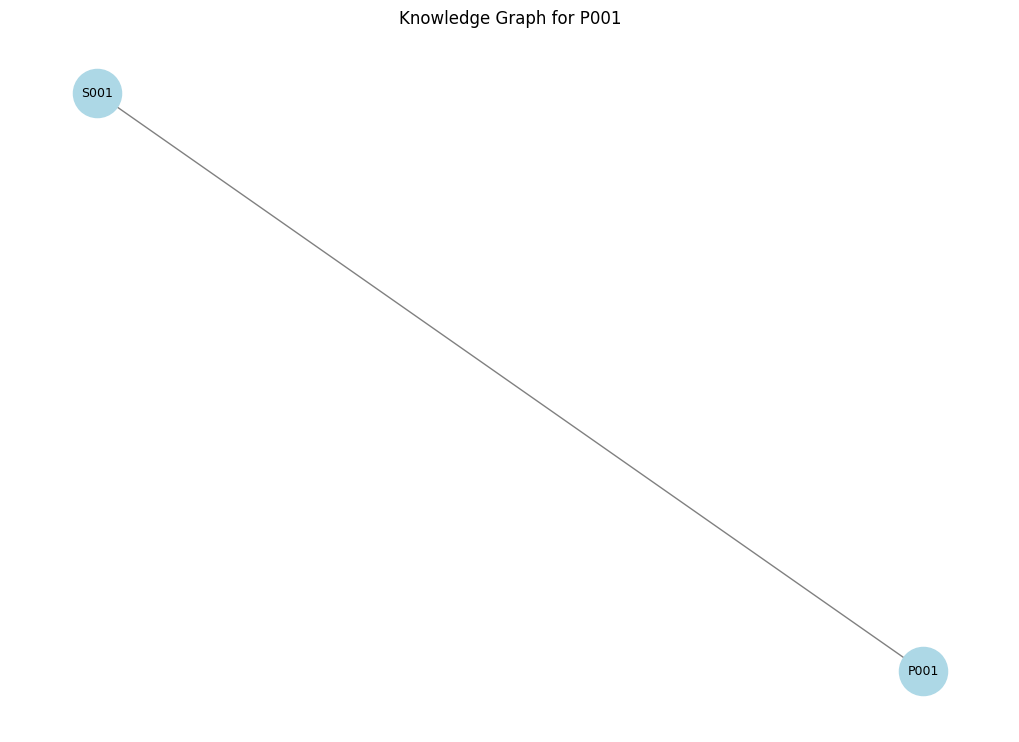

In [ ]:
# Pick a few nodes (first patient's subgraph)
sample_patient = df['patient_id'].iloc[0]
neighbors = list(G.neighbors(sample_patient))

sub_nodes = [sample_patient] + neighbors
subgraph = G.subgraph(sub_nodes)

plt.figure(figsize=(10,7))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=1200, font_size=9, node_color="lightblue", edge_color="gray")
plt.title(f"Knowledge Graph for {sample_patient}")
plt.show()



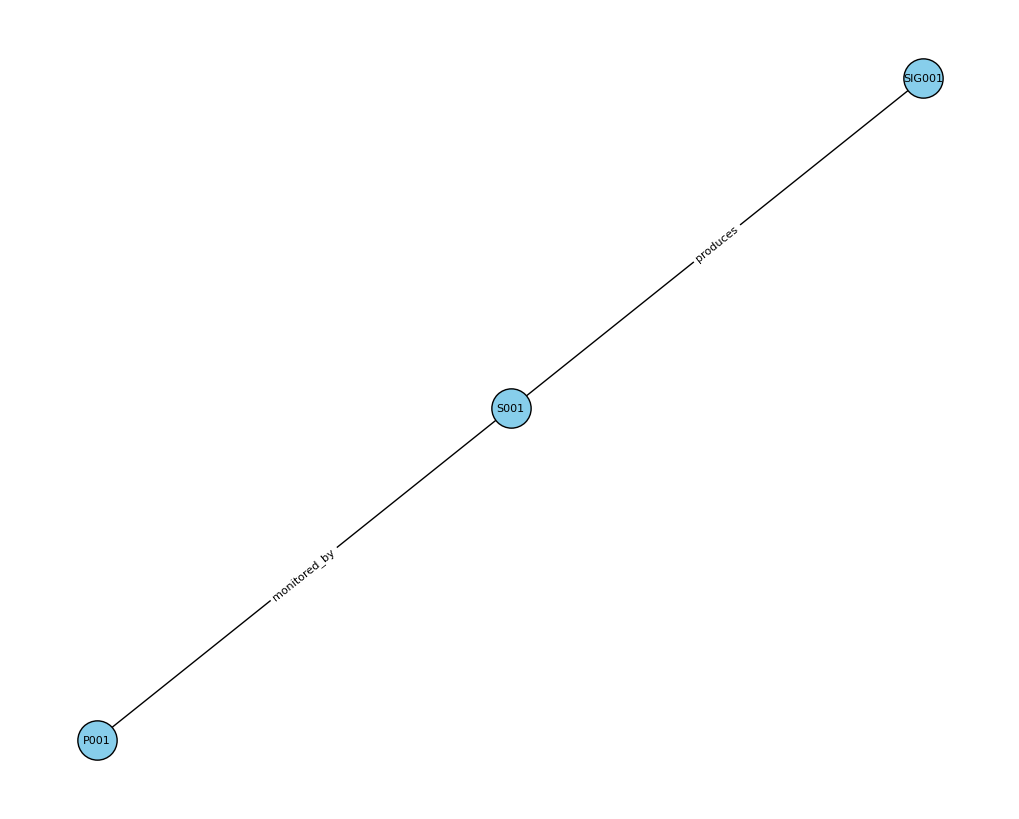

In [ ]:
node = 'S001'  # pick any node you want to explore
neighbors = list(G.neighbors(node)) + [node]
subgraph = G.subgraph(neighbors)

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=8, node_color='skyblue', edgecolors='k')

# show relationship types on edges
edge_labels = nx.get_edge_attributes(subgraph, 'relation')
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=8)

plt.show()


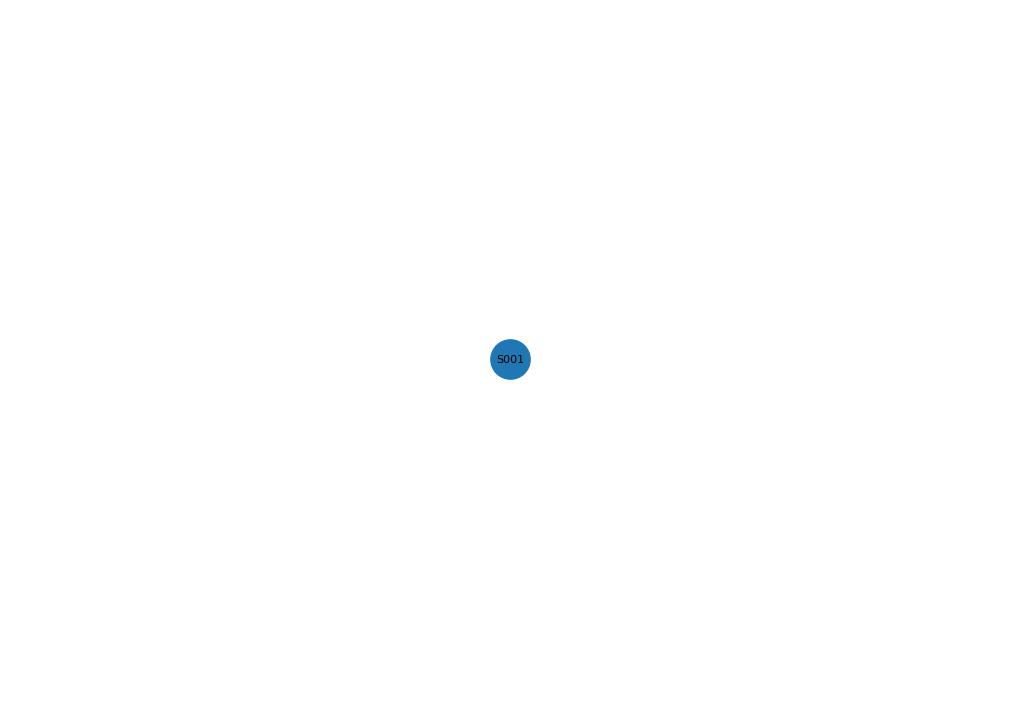

In [ ]:
# Take a small sample to visualize
sub_nodes = list(df['patient_id'][:5])  # First 5 patients
subgraph = G.subgraph(nx.neighbors(G, sub_nodes[0]))  # sample view

plt.figure(figsize=(10, 7))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw(subgraph, pos, with_labels=True, node_size=800, font_size=8)
plt.show()


In [ ]:
summary = {}
condition_nodes = [n for n, attr in G.nodes(data=True) if attr.get('type') == 'Condition']

for cond in condition_nodes:
    patients = [p for p in df['patient_id'].unique() if nx.has_path(G, p, cond)]
    summary[cond] = patients

for cond, pats in summary.items():
    print(f"{cond}: {len(pats)} patients -> {pats[:5]}")


Prehypertension: 100 patients -> ['P001', 'P002', 'P003', 'P004', 'P005']
Hypertension Stage 2: 100 patients -> ['P001', 'P002', 'P003', 'P004', 'P005']
Normal: 100 patients -> ['P001', 'P002', 'P003', 'P004', 'P005']
Hypertension Stage 1: 100 patients -> ['P001', 'P002', 'P003', 'P004', 'P005']


In [ ]:
target_condition = "Hypertension Stage 2"  # pick one from the printed list

patients_with_condition = []
for patient in df['patient_id'].unique():
    if nx.has_path(G, patient, target_condition):
        patients_with_condition.append(patient)

print(f"Patients diagnosed with {target_condition}:")
print(patients_with_condition)
print("Total:", len(patients_with_condition))



Patients diagnosed with Hypertension Stage 2:
['P001', 'P002', 'P003', 'P004', 'P005', 'P006', 'P007', 'P008', 'P009', 'P010', 'P011', 'P012', 'P013', 'P014', 'P015', 'P016', 'P017', 'P018', 'P019', 'P020', 'P021', 'P022', 'P023', 'P024', 'P025', 'P026', 'P027', 'P028', 'P029', 'P030', 'P031', 'P032', 'P033', 'P034', 'P035', 'P036', 'P037', 'P038', 'P039', 'P040', 'P041', 'P042', 'P043', 'P044', 'P045', 'P046', 'P047', 'P048', 'P049', 'P050', 'P051', 'P052', 'P053', 'P054', 'P055', 'P056', 'P057', 'P058', 'P059', 'P060', 'P061', 'P062', 'P063', 'P064', 'P065', 'P066', 'P067', 'P068', 'P069', 'P070', 'P071', 'P072', 'P073', 'P074', 'P075', 'P076', 'P077', 'P078', 'P079', 'P080', 'P081', 'P082', 'P083', 'P084', 'P085', 'P086', 'P087', 'P088', 'P089', 'P090', 'P091', 'P092', 'P093', 'P094', 'P095', 'P096', 'P097', 'P098', 'P099', 'P100']
Total: 100
